# Import

In [2]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 20 kB/s 


In [1]:
import zipfile
import warnings

from catboost import CatBoostRegressor
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split


warnings.filterwarnings("ignore")

In [2]:
PATH_TO_ARCHIVE = '/content/drive/MyDrive/open_data_battle/mpp/mpp.zip'
PATH_TO_OUT_DIR = '/content/drive/MyDrive/open_data_battle/mpp/'

PATH_TO_DATA = '/content/drive/MyDrive/open_data_battle/mpp/data.csv'
PATH_TO_DATA_MODEL = '/content/drive/MyDrive/open_data_battle/mpp/model.csv'
SUBMISSION_PATH = '/content/drive/MyDrive/open_data_battle/mpp/submissin.csv'

RANDOM_STATE = 17

# Additional functions


In [3]:
def zip_extract(path_in: str, path_out: str) -> None:
    with zipfile.ZipFile(path_in, 'r') as archive:
      archive.extractall(path_out)


def get_unique_features_name(features: pd.DataFrame) -> list:
  
    no_feature = [x for x in features if 'Feature' not in x]
    is_feature = list(set(
        ['_'.join(x.split('_')[:-1]) for x in features if 'Feature' in x]))
    
    return no_feature + is_feature


def get_cat_features(features: pd.DataFrame) -> list:
    return [x for x in features if 'Category_Feature' in x]

# Extract files

In [4]:
zip_extract(PATH_TO_ARCHIVE, PATH_TO_OUT_DIR)

# EDA

In [5]:
data = pd.read_csv(PATH_TO_DATA)
data_model = pd.read_csv(PATH_TO_DATA_MODEL)

print(data.shape, data_model.shape)

(82617, 1910) (82617, 2)


In [6]:
# Split data on target and train
data_target = data[data['flg_90_12_add'].isna()]
data_train = data[~data['flg_90_12_add'].isna()]
data_model_target = data_model[data_model['PD'].isna()]
data_model_train = data_model[~data_model['PD'].isna()]

print(data_target.shape, data_train.shape, data_model_target.shape, data_model_train.shape)

(1000, 1910) (81617, 1910) (1000, 2) (81617, 2)


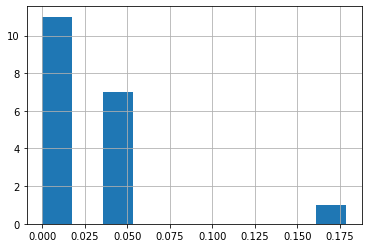

In [10]:
# NA distribution of cat features
(data_train[get_cat_features(data_train)].isna().sum() / len(data_train)).hist();

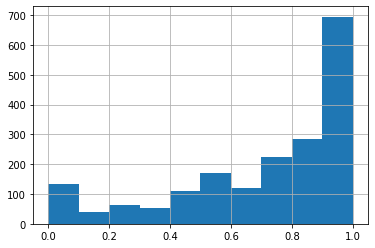

In [11]:
# NA distribution of numeric features
(data_train[[x for x in data_train if x not in get_cat_features(data_train)]]
 .isna().sum() 
 /len(data_train)).hist();

In [12]:
# Unique name in data_train
get_unique_features_name(data)

['incident',
 'flg_90_12_add',
 'APPLICATION_MONTH',
 'Category_Feature',
 'Feature']

In [13]:
# Join data and data_model
df_train = data_train.merge(data_model_train, on='incident', how='inner')
print(df_train.shape, data_train.shape, data_model_train.shape)

(81617, 1911) (81617, 1910) (81617, 2)


In [14]:
# Calculate target
df_train['y'] = abs(df_train['PD'] - df_train['flg_90_12_add'])

In [15]:
# Extract year and month
df_train['Year'] = (df_train['APPLICATION_MONTH']
                    .apply(lambda x: x.split('-')[0]))
df_train['Month'] = (df_train['APPLICATION_MONTH']
                     .apply(lambda x: x.split('-')[1]))

data_target['Year'] = (data_target['APPLICATION_MONTH']
                       .apply(lambda x: x.split('-')[0]))
data_target['Month'] = (data_target['APPLICATION_MONTH']
                        .apply(lambda x: x.split('-')[1]))

# Split data

In [16]:
drop_cols = ['PD', 'flg_90_12_add', 'incident', 'APPLICATION_MONTH']
X_train, X_test = train_test_split(
    df_train.drop(drop_cols, axis=1), test_size=0.15, random_state=RANDOM_STATE)
X_train, X_valid = train_test_split(
    df_train.drop(drop_cols, axis=1), test_size=0.15, random_state=RANDOM_STATE)

print(X_train.shape, X_test.shape, X_valid.shape)

(69374, 1910) (12243, 1910) (12243, 1910)


# Fill na

In [17]:
# Fill na value in cat features with mode and numeric features with mean
# Use only train data for creating raplace dicts

fill_na_rate = 1
replace_cat_na = {
    x: X_train[x].mode().values[0] for x in get_cat_features(list(X_train))
    }

na_distr = (
    X_train[[x for x in X_train if x not in get_cat_features(X_train)]]
    .isna()
    .sum() 
    / len(X_train)
    )

na_float_features = [x for x in na_distr[na_distr <= fill_na_rate].index 
                     if x.split('_')[0] == 'Feature']
replace_float_na = {x: X_train[x].mean() for x in na_float_features}

for cat_feature in get_cat_features(X_train):
  X_train[cat_feature] = (X_train[cat_feature]
                          .fillna(replace_cat_na[cat_feature])
                          .astype(int))
  X_test[cat_feature] = (X_test[cat_feature]
                         .fillna(replace_cat_na[cat_feature])
                         .astype(int))
  X_valid[cat_feature] = (X_valid[cat_feature]
                          .fillna(replace_cat_na[cat_feature])
                          .astype(int))
  data_target[cat_feature] = (data_target[cat_feature]
                              .fillna(replace_cat_na[cat_feature])
                              .astype(int))

for float_feature in replace_float_na.keys():
  X_train[float_feature] = (X_train[float_feature]
                            .fillna(replace_float_na[float_feature]))
  X_test[float_feature] = (X_test[float_feature]
                           .fillna(replace_float_na[float_feature]))
  X_valid[float_feature] = (X_valid[float_feature]
                            .fillna(replace_float_na[float_feature]))
  data_target[float_feature] = (data_target[float_feature]
                                .fillna(replace_float_na[float_feature]))

In [19]:
# Drop feature with na value
X_train = X_train.dropna(1)
X_test = X_test.dropna(1)
X_valid = X_valid.dropna(1)
data_target = data_target.dropna(1)

# Catboost model

## Train model

In [21]:
model_params = {
    'iterations': 4000, 
    'loss_function': 'MAE',
    'eval_metric': 'MAE',
    'random_seed': RANDOM_STATE,
    'early_stopping_rounds': 300,
    'learning_rate': 0.02,
    'depth': 10,
    'l2_leaf_reg': 6,
    'cat_features': get_cat_features(X_train) + ['Year', 'Month'],
    'nan_mode': 'Min',
    'task_type': 'GPU'
    }

model_cb = CatBoostRegressor(**model_params, )

In [22]:
model_cb.fit(
    X=X_train.drop('y', axis=1), 
    y=X_train['y'].apply(lambda x: np.log(x)), 
    eval_set=(X_valid.drop('y', axis=1), 
              X_valid['y'].apply(lambda x: np.log(x))),
    verbose=100
    )

0:	learn: 0.7730214	test: 0.7859282	best: 0.7859282 (0)	total: 552ms	remaining: 36m 46s
100:	learn: 0.5179339	test: 0.5417957	best: 0.5417957 (100)	total: 41.9s	remaining: 26m 55s
200:	learn: 0.4804848	test: 0.5153720	best: 0.5153720 (200)	total: 1m 18s	remaining: 24m 44s
300:	learn: 0.4662201	test: 0.5091184	best: 0.5091184 (300)	total: 1m 53s	remaining: 23m 17s
400:	learn: 0.4566673	test: 0.5063842	best: 0.5063842 (400)	total: 2m 27s	remaining: 22m 7s
500:	learn: 0.4489375	test: 0.5043947	best: 0.5043947 (500)	total: 3m 1s	remaining: 21m 8s
600:	learn: 0.4412525	test: 0.5028030	best: 0.5028030 (600)	total: 3m 36s	remaining: 20m 23s
700:	learn: 0.4338074	test: 0.5017920	best: 0.5017885 (699)	total: 4m 10s	remaining: 19m 40s
800:	learn: 0.4270850	test: 0.5010346	best: 0.5010300 (798)	total: 4m 45s	remaining: 18m 58s
900:	learn: 0.4210692	test: 0.5004376	best: 0.5004328 (899)	total: 5m 19s	remaining: 18m 18s
1000:	learn: 0.4154122	test: 0.4998884	best: 0.4998884 (1000)	total: 5m 53s	rem

## Evaluate model 

In [23]:
y_pred_test = model_cb.predict(X_test.drop('y', axis=1))
y_pred_valid = model_cb.predict(X_valid.drop('y', axis=1))

In [24]:
print(f"Valid MAE: {mean_absolute_error(X_valid['y'], np.exp(y_pred_valid)):.4f}")
print(f"Test MAE: {mean_absolute_error(X_test['y'], np.exp(y_pred_test)):.4f}")

Valid MAE: 0.0607
Test MAE: 0.0607


## Submission

In [25]:
cols_target = X_train.drop('y', axis=1).columns
sub_pred = model_cb.predict(data_target[cols_target])
pd.Series(np.exp(sub_pred)).to_csv(SUBMISSION_PATH, index=False, header=False)